In [1]:
#Import libraries
import shap
from sklearn.linear_model import LinearRegression
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam


In [2]:
#Fetch historical weather data (NWP) from Open-Meteo API

# Define API parameters(For London)
latitude = 51.5074
longitude = -0.1278
start_date = "2015-01-01"
end_date = "2022-01-01"
variables = [
    "wind_speed_10m", "wind_direction_10m",
    "wind_speed_100m", "wind_direction_100m",
    "temperature_2m", "surface_pressure",
    "relative_humidity_2m", "direct_radiation"
]

hourly_vars = ",".join(variables)
url = (
    f"https://archive-api.open-meteo.com/v1/archive?"
    f"latitude={latitude}&longitude={longitude}"
    f"&start_date={start_date}&end_date={end_date}"
    f"&hourly={hourly_vars}&timezone=UTC"
)

#Get the data
response = requests.get(url)
data = response.json()
nwp_data = pd.DataFrame(data["hourly"])


In [3]:
#Format and save the NWP data to CSV

nwp_data["utc_timestamp"] = pd.to_datetime(nwp_data["time"])
nwp_data.drop(columns=["time"], inplace=True)
nwp_data.to_csv("london_nwp_data.csv", index=False)


In [4]:
nwp_data.head()


,wind_speed_10m,wind_direction_10m,wind_speed_100m,wind_direction_100m,temperature_2m,surface_pressure,relative_humidity_2m,direct_radiation,utc_timestamp
0,21.1,207,36.8,211,4.7,1030.2,93,0.0,2015-01-01 00:00:00
1,20.6,209,35.0,212,5.0,1029.7,93,0.0,2015-01-01 01:00:00
2,19.9,215,33.6,218,5.3,1029.6,93,0.0,2015-01-01 02:00:00
3,18.7,214,32.0,218,5.7,1029.7,93,0.0,2015-01-01 03:00:00
4,19.7,211,33.7,215,6.0,1029.5,93,0.0,2015-01-01 04:00:00


In [5]:
#Load wind generation and weather forecast datasets


wind_data = pd.read_csv("time_series_60min_singleindex.csv", parse_dates=['utc_timestamp'])

weather_data = pd.read_csv("weather_data.csv", parse_dates=['utc_timestamp'])


In [6]:

print("Wind Data Sample:")
display(wind_data.head())

print("Weather Data Sample:")
display(weather_data.head())


Wind Data Sample:


,utc_timestamp,cet_cest_timestamp,AT_load_actual_entsoe_transparency,AT_load_forecast_entsoe_transparency,AT_price_day_ahead,AT_solar_generation_actual,AT_wind_onshore_generation_actual,BE_load_actual_entsoe_transparency,BE_load_forecast_entsoe_transparency,BE_solar_generation_actual,...,SI_load_actual_entsoe_transparency,SI_load_forecast_entsoe_transparency,SI_solar_generation_actual,SI_wind_onshore_generation_actual,SK_load_actual_entsoe_transparency,SK_load_forecast_entsoe_transparency,SK_solar_generation_actual,SK_wind_onshore_generation_actual,UA_load_actual_entsoe_transparency,UA_load_forecast_entsoe_transparency
0,2014-12-31 23:00:00+00:00,2015-01-01T00:00:00+0100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-01-01 00:00:00+00:00,2015-01-01T01:00:00+0100,5946.0,6701.0,35.0,NaN,69.0,9484.0,9897.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2015-01-01 01:00:00+00:00,2015-01-01T02:00:00+0100,5726.0,6593.0,45.0,NaN,64.0,9152.0,9521.0,NaN,...,1045.47,816.0,NaN,1.17,2728.0,2860.0,3.8,NaN,NaN,NaN
3,2015-01-01 02:00:00+00:00,2015-01-01T03:00:00+0100,5347.0,6482.0,41.0,NaN,65.0,8799.0,9135.0,NaN,...,1004.79,805.0,NaN,1.04,2626.0,2810.0,3.8,NaN,NaN,NaN
4,2015-01-01 03:00:00+00:00,2015-01-01T04:00:00+0100,5249.0,6454.0,38.0,NaN,64.0,8567.0,8909.0,NaN,...,983.79,803.0,NaN,1.61,2618.0,2780.0,3.8,NaN,NaN,NaN


Weather Data Sample:


,utc_timestamp,AT_temperature,AT_radiation_direct_horizontal,AT_radiation_diffuse_horizontal,BE_temperature,BE_radiation_direct_horizontal,BE_radiation_diffuse_horizontal,BG_temperature,BG_radiation_direct_horizontal,BG_radiation_diffuse_horizontal,...,RO_radiation_diffuse_horizontal,SE_temperature,SE_radiation_direct_horizontal,SE_radiation_diffuse_horizontal,SI_temperature,SI_radiation_direct_horizontal,SI_radiation_diffuse_horizontal,SK_temperature,SK_radiation_direct_horizontal,SK_radiation_diffuse_horizontal
0,1980-01-01 00:00:00+00:00,-3.640,0.0,0.0,-0.720,0.0,0.0,4.664,0.0,0.0,...,0.0,-3.945,0.0,0.0,-3.055,0.0,0.0,-4.648,0.0,0.0
1,1980-01-01 01:00:00+00:00,-3.803,0.0,0.0,-1.165,0.0,0.0,4.052,0.0,0.0,...,0.0,-4.053,0.0,0.0,-3.272,0.0,0.0,-4.554,0.0,0.0
2,1980-01-01 02:00:00+00:00,-3.969,0.0,0.0,-1.434,0.0,0.0,3.581,0.0,0.0,...,0.0,-4.129,0.0,0.0,-3.639,0.0,0.0,-4.455,0.0,0.0
3,1980-01-01 03:00:00+00:00,-4.076,0.0,0.0,-1.843,0.0,0.0,3.197,0.0,0.0,...,0.0,-4.139,0.0,0.0,-4.202,0.0,0.0,-4.421,0.0,0.0
4,1980-01-01 04:00:00+00:00,-4.248,0.0,0.0,-2.094,0.0,0.0,2.750,0.0,0.0,...,0.0,-4.239,0.0,0.0,-4.732,0.0,0.0,-4.449,0.0,0.0


In [7]:
#Filter GB-specific columns and remove solar related columns

gb_wind_columns = [col for col in wind_data.columns if col.startswith("GB_") and "solar" not in col.lower()]
gb_wind_data = wind_data[["utc_timestamp"] + gb_wind_columns]

gb_weather_columns = [col for col in weather_data.columns if col.startswith("GB_")]
gb_weather_data = weather_data[["utc_timestamp"] + gb_weather_columns]


In [8]:
# Set timestamp as index for merging
gb_wind_data.set_index("utc_timestamp", inplace=True)
gb_weather_data.set_index("utc_timestamp", inplace=True)

# Merge wind and weather data
merged_gb_data = pd.merge(gb_wind_data, gb_weather_data, how="left", left_index=True, right_index=True)


In [9]:
# Load saved NWP data
nwp_data = pd.read_csv("london_nwp_data.csv", parse_dates=["utc_timestamp"])
nwp_data.set_index("utc_timestamp", inplace=True)

# Ensure datetime index is naive (no timezone)
merged_gb_data.index = merged_gb_data.index.tz_localize(None)
nwp_data.index = nwp_data.index.tz_localize(None)

# Merge final dataset
final_combined_df = pd.merge(merged_gb_data, nwp_data, how="left", left_index=True, right_index=True)


In [10]:
final_combined_df.head()


,GB_GBN_load_actual_entsoe_transparency,GB_GBN_load_forecast_entsoe_transparency,GB_GBN_price_day_ahead,GB_GBN_wind_capacity,GB_GBN_wind_generation_actual,GB_GBN_wind_profile,GB_GBN_wind_offshore_capacity,GB_GBN_wind_offshore_generation_actual,GB_GBN_wind_offshore_profile,GB_GBN_wind_onshore_capacity,...,GB_radiation_direct_horizontal,GB_radiation_diffuse_horizontal,wind_speed_10m,wind_direction_10m,wind_speed_100m,wind_direction_100m,temperature_2m,surface_pressure,relative_humidity_2m,direct_radiation
utc_timestamp,,,,,,,,,,,,,,,,,,,,,
2014-12-31 23:00:00,NaN,NaN,NaN,11554.0,NaN,NaN,4040.0,NaN,NaN,7514.0,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-01 00:00:00,26758.0,32057.0,NaN,11555.0,NaN,NaN,4040.0,NaN,NaN,7516.0,...,0.0,0.0,21.1,207.0,36.8,211.0,4.7,1030.2,93.0,0.0
2015-01-01 01:00:00,27166.0,31738.0,NaN,11555.0,782.0,0.0676,4040.0,117.0,0.0290,7516.0,...,0.0,0.0,20.6,209.0,35.0,212.0,5.0,1029.7,93.0,0.0
2015-01-01 02:00:00,24472.0,30690.0,NaN,11555.0,785.0,0.0680,4040.0,120.0,0.0296,7516.0,...,0.0,0.0,19.9,215.0,33.6,218.0,5.3,1029.6,93.0,0.0
2015-01-01 03:00:00,23003.0,28442.0,NaN,11555.0,776.0,0.0672,4040.0,115.0,0.0284,7516.0,...,0.0,0.0,18.7,214.0,32.0,218.0,5.7,1029.7,93.0,0.0


In [11]:
#Drop data before January 1, 2015 (to remove rows with excessive missing values)

cleaned_df = final_combined_df.loc["2015-01-01":]

#Forward-fill missing values
cleaned_df = cleaned_df.ffill()

#Interpolate remaining missing values using time method

cleaned_df = cleaned_df.interpolate(method='time')

#Drop rows that still have missing values

cleaned_df = cleaned_df.dropna()





In [12]:
#Display shape and summary of cleaned dataset

print("Shape of cleaned dataset:", cleaned_df.shape)
cleaned_df.describe()
cleaned_df.to_csv("cleaned_combined_dataset.csv", index=False)


Shape of cleaned dataset: (50280, 35)


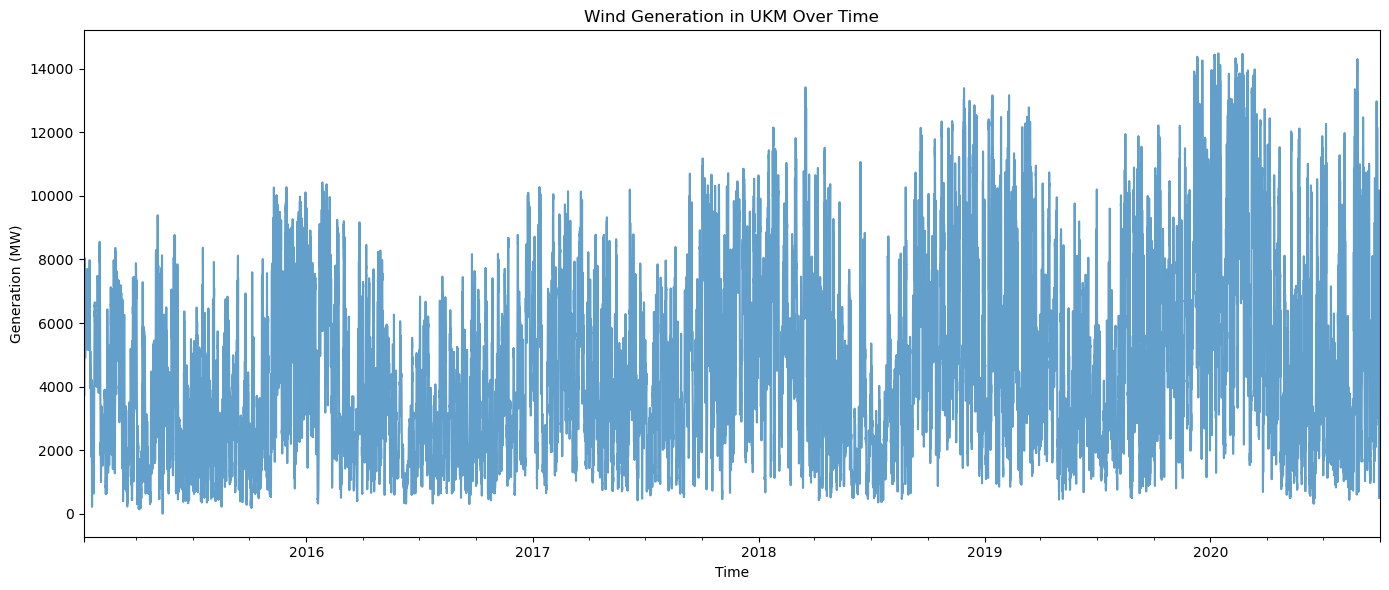

In [13]:
# Plot wind generation over time for GB_UKM

plt.figure(figsize=(14, 6))
cleaned_df['GB_UKM_wind_generation_actual'].plot(alpha=0.7)
plt.title('Wind Generation in UKM Over Time')
plt.xlabel('Time')
plt.ylabel('Generation (MW)')
plt.tight_layout()
plt.show()


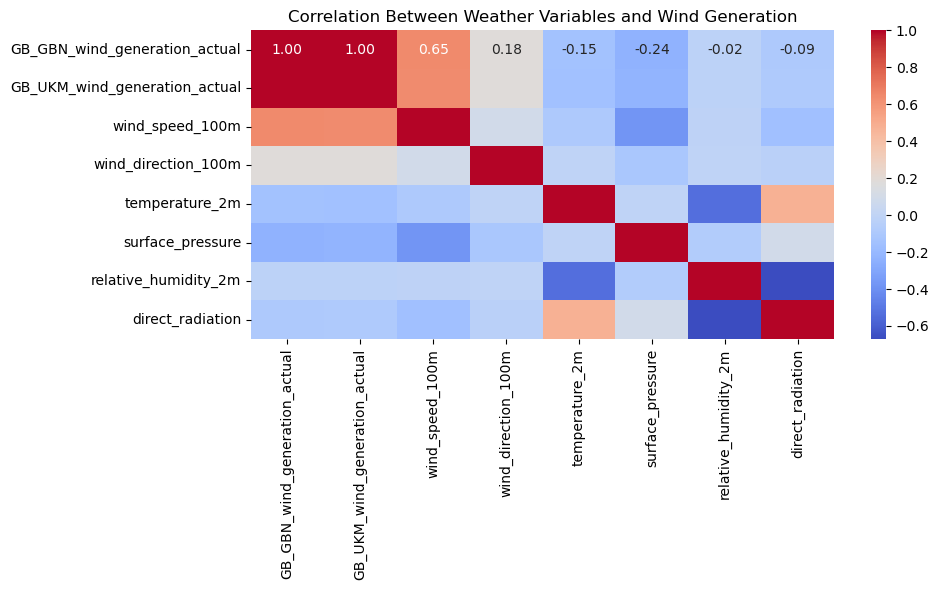

In [14]:
#Correlation heatmap between weather variables and wind generation

selected_cols = [
    'GB_GBN_wind_generation_actual',
    'GB_UKM_wind_generation_actual',
    'wind_speed_100m',
    'wind_direction_100m',
    'temperature_2m',
    'surface_pressure',
    'relative_humidity_2m',
    'direct_radiation'
]

corr_data = cleaned_df[selected_cols].dropna()

corr_matrix = corr_data.corr()

plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Between Weather Variables and Wind Generation")
plt.tight_layout()
plt.show()


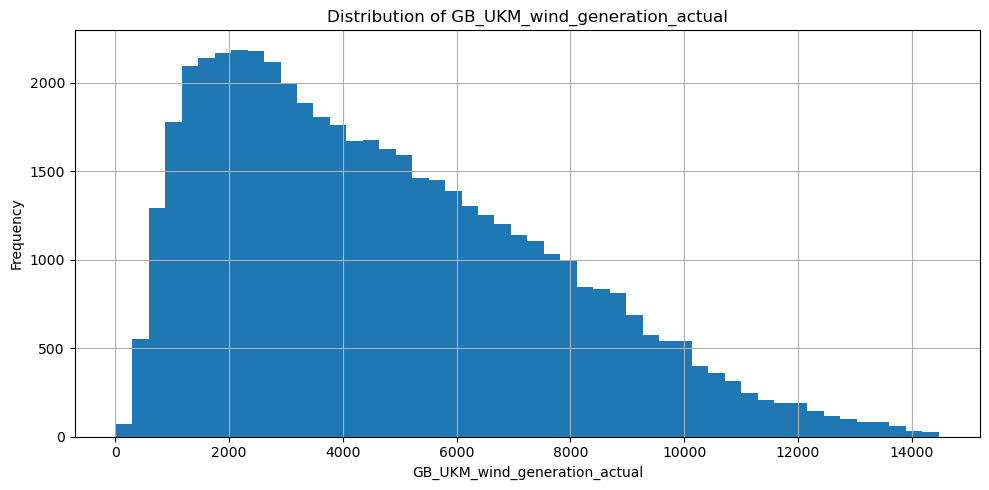

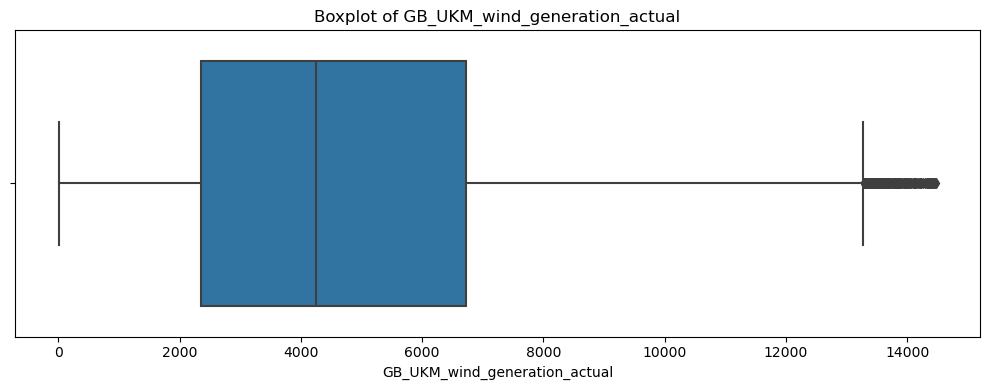

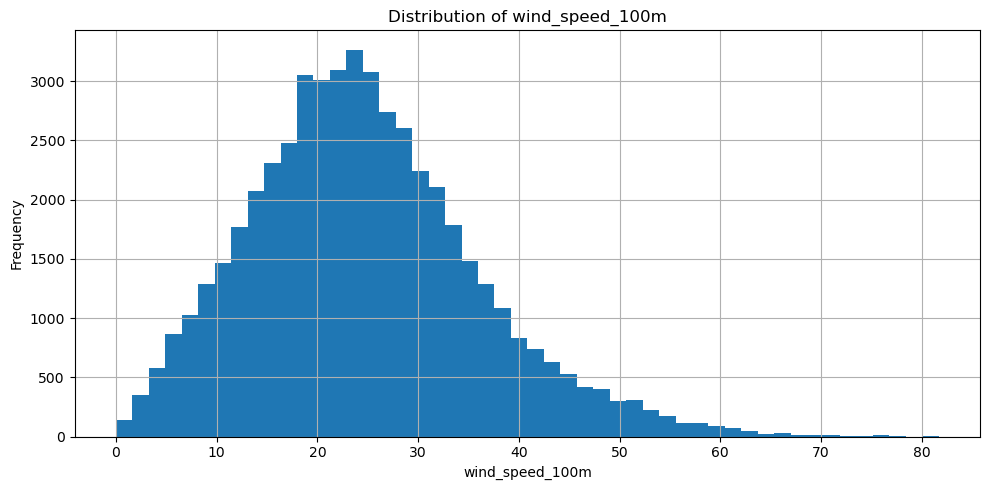

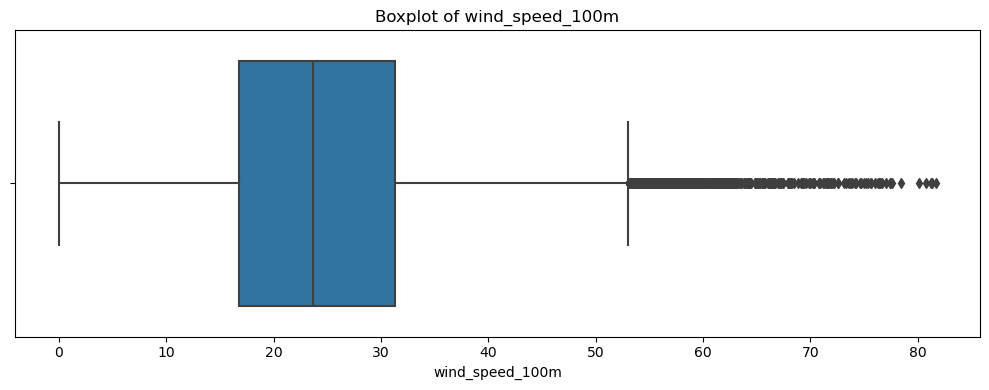

In [15]:
# Visualize distributions with histograms and boxplots

features = ['GB_UKM_wind_generation_actual', 'wind_speed_100m']

for feature in features:
    # Histogram
    plt.figure(figsize=(10, 5))
    cleaned_df[feature].dropna().hist(bins=50)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

    # Boxplot
    plt.figure(figsize=(10, 4))
    sns.boxplot(x=cleaned_df[feature])
    plt.title(f'Boxplot of {feature}')
    plt.xlabel(feature)
    plt.tight_layout()
    plt.show()


In [16]:
def load_and_preprocess(path, target='GB_UKM_wind_generation_actual'):
    df = pd.read_csv(path)
    for lag in range(1, 6):
        df[f'lag_{lag}'] = df[target].shift(lag)
    df['wind_speed_100m_rolling_mean'] = df['wind_speed_100m'].rolling(window=3).mean()
    df['wind_speed_10m_rolling_mean'] = df['wind_speed_10m'].rolling(window=3).mean()
    df['onshore_offshore_ratio'] = (
        df['GB_UKM_wind_onshore_generation_actual'] /
        (df['GB_UKM_wind_offshore_generation_actual'] + 1e-6)
    )
    df = df.dropna()
    
    X = df.drop(columns=[target])
    y = df[target].values.reshape(-1, 1)

    x_scaler = MinMaxScaler()
    X_scaled = x_scaler.fit_transform(X)
    y_scaler = MinMaxScaler()
    y_scaled = y_scaler.fit_transform(y)

    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y_scaled, test_size=0.2, random_state=42
    )
    X_train_lstm = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
    X_test_lstm  = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

    return X_train_lstm, X_test_lstm, y_train, y_test, y_scaler, df, X, y


In [17]:
# Build models
def build_lstm(input_shape):
    m = Sequential()
    m.add(LSTM(64, activation='relu', input_shape=input_shape))
    m.add(Dropout(0.2))
    m.add(Dense(32, activation='relu'))
    m.add(Dense(1))
    m.compile(optimizer=Adam(0.001), loss='mse')
    return m

def build_bilstm(input_shape):
    m = Sequential()
    m.add(Bidirectional(LSTM(64, activation='relu'), input_shape=input_shape))
    m.add(Dropout(0.2))
    m.add(Dense(32, activation='relu'))
    m.add(Dense(1))
    m.compile(optimizer=Adam(0.001), loss='mse')
    return m

In [18]:
path = "cleaned_combined_dataset.csv"
X_train, X_test, y_train, y_test, y_scaler, df, X, y = load_and_preprocess(path)
input_shape = (X_train.shape[1], X_train.shape[2])

In [19]:
# SHAP with Linear Regression on unscaled data
X_train_exp, X_test_exp, y_train_exp, y_test_exp = train_test_split(X, y, test_size=0.2, random_state=42)
simple_model = LinearRegression()
simple_model.fit(X_train_exp, y_train_exp)

explainer = shap.Explainer(simple_model.predict, X_train_exp)
shap_values = explainer(X_test_exp[:100])



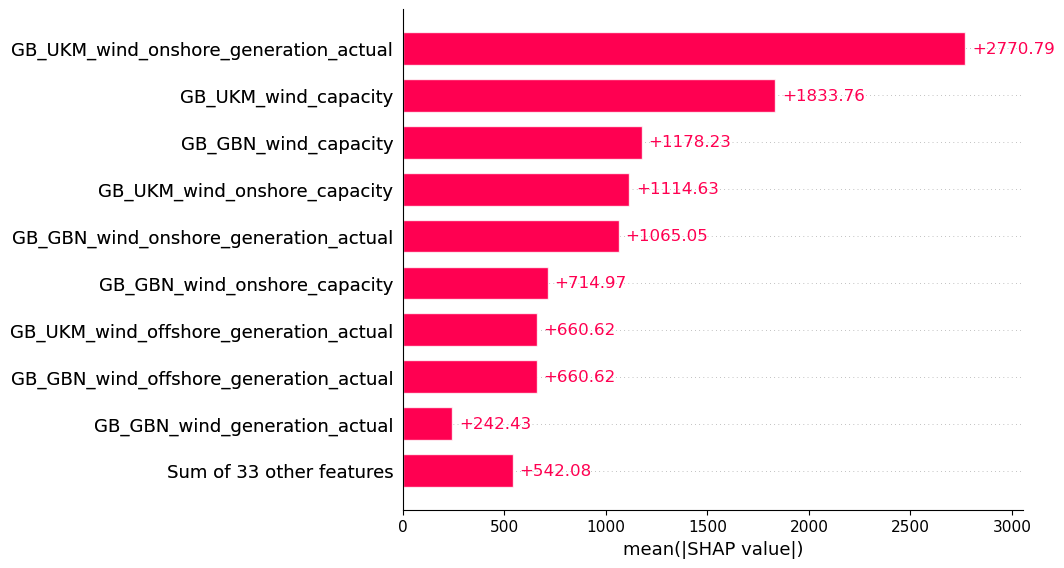

In [20]:
#Bar plot
shap.plots.bar(shap_values)

In [26]:
# Train Models and Capture Predictions
models = {
    'LSTM': build_lstm(input_shape),
    'BiLSTM': build_bilstm(input_shape)
}

results = []
predictions = {} 

for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=0)
    
    y_pred = y_scaler.inverse_transform(model.predict(X_test))
    y_true = y_scaler.inverse_transform(y_test)
    
    predictions[name] = (y_true.flatten(), y_pred.flatten())
    
    # Calculate metrics
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    
    results.append({'Model': name, 'R2': r2, 'RMSE': rmse, 'MAE': mae})

# Display Evaluation Table
res_df = pd.DataFrame(results)
print("\nPerformance Comparison:")
print(res_df)


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Training LSTM...


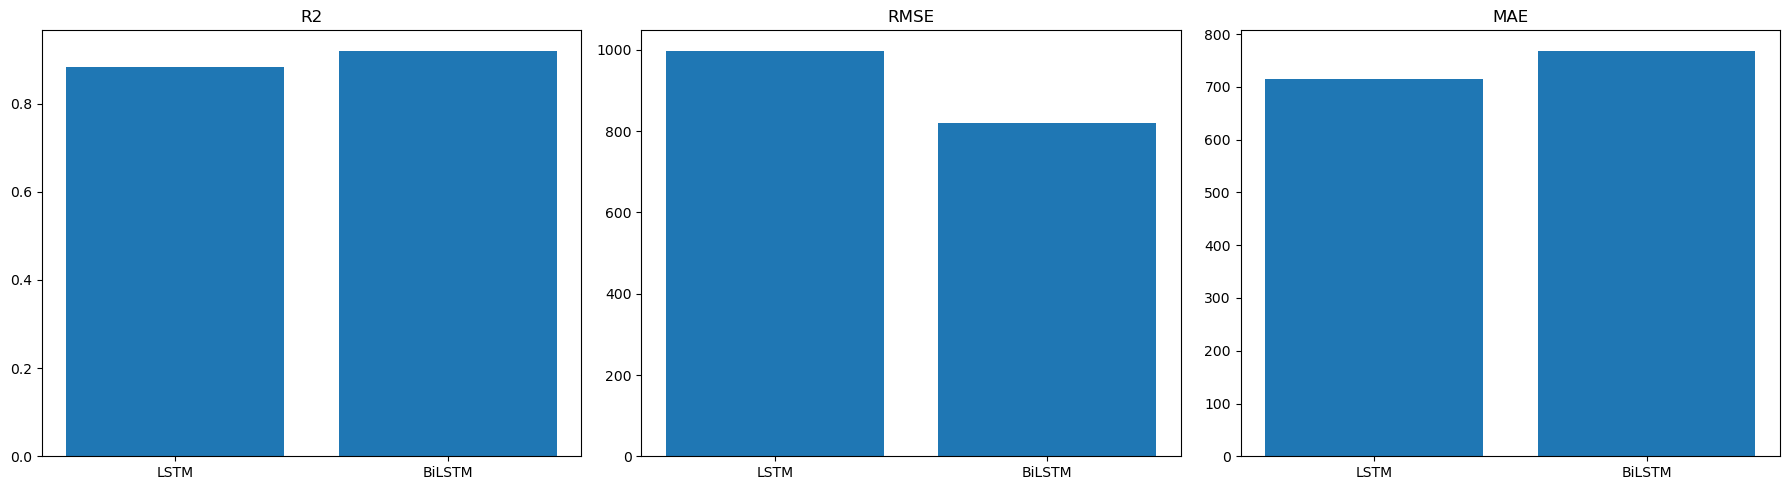

In [ ]:
#Visualisation of different metrics
metrics = ['R2', 'RMSE', 'MAE']
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for ax, m in zip(axes, metrics):
    ax.bar(res_df['Model'], res_df[m])
    ax.set_title(m)
plt.tight_layout()
plt.show()

315/315 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
315/315 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


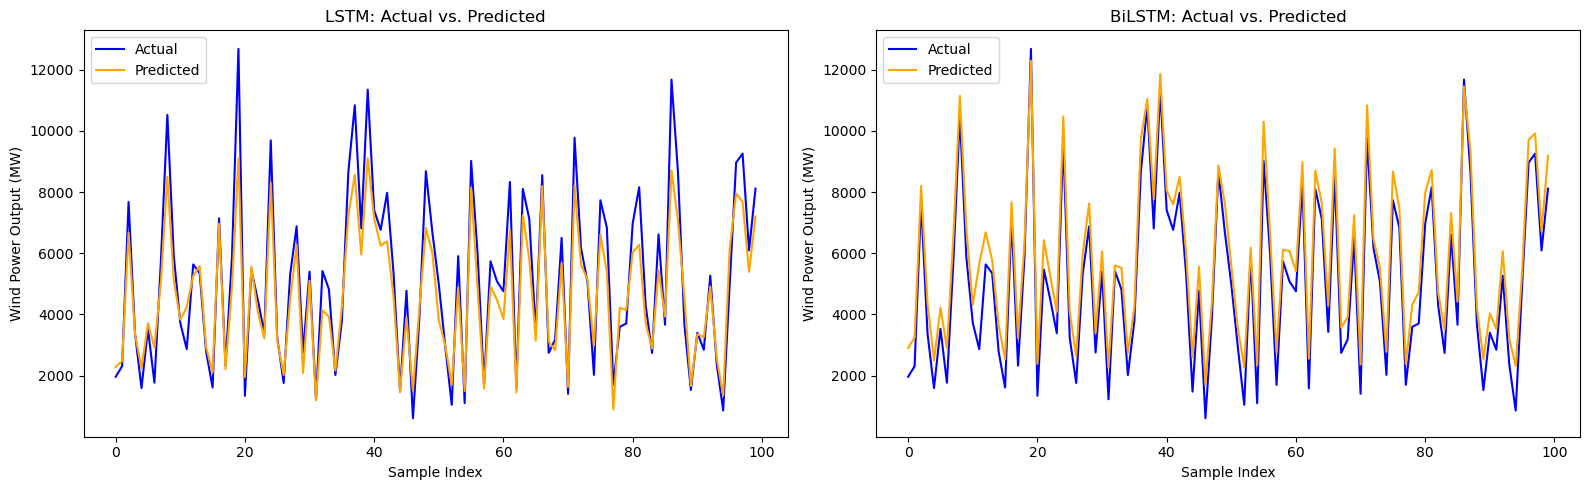

In [ ]:
#Model comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

for ax, (name, model) in zip(axes, models.items()):
    y_pred = y_scaler.inverse_transform(model.predict(X_test))
    y_true = y_scaler.inverse_transform(y_test)

    ax.plot(y_true[:100], label='Actual', color='blue')
    ax.plot(y_pred[:100], label='Predicted', color='orange')
    ax.set_title(f'{name}: Actual vs. Predicted')
    ax.set_xlabel('Sample Index')
    ax.set_ylabel('Wind Power Output (MW)')
    ax.legend()

plt.tight_layout()
plt.show()


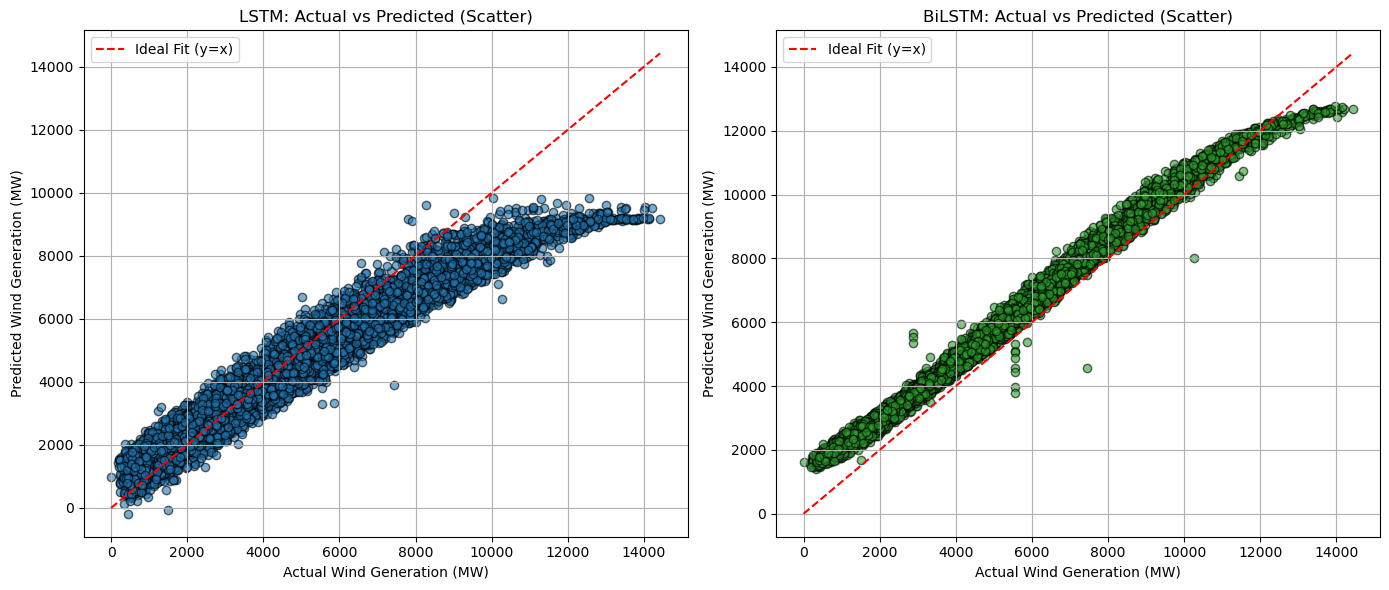

In [ ]:
plt.figure(figsize=(14, 6))

# LSTM Plot
plt.subplot(1, 2, 1)
y_true_lstm, y_pred_lstm = predictions['LSTM']
plt.scatter(y_true_lstm, y_pred_lstm, alpha=0.6, edgecolors='k', color='#1f77b4')
plt.plot([0, max(y_true_lstm)], [0, max(y_true_lstm)], 'r--', label='Ideal Fit (y=x)')
plt.xlabel("Actual Wind Generation (MW)")
plt.ylabel("Predicted Wind Generation (MW)")
plt.title("LSTM: Actual vs Predicted (Scatter)")
plt.legend()
plt.grid(True)

# BiLSTM Plot
plt.subplot(1, 2, 2)
y_true_bilstm, y_pred_bilstm = predictions['BiLSTM']
plt.scatter(y_true_bilstm, y_pred_bilstm, alpha=0.6, edgecolors='k', color='#2ca02c')
plt.plot([0, max(y_true_bilstm)], [0, max(y_true_bilstm)], 'r--', label='Ideal Fit (y=x)')
plt.xlabel("Actual Wind Generation (MW)")
plt.ylabel("Predicted Wind Generation (MW)")
plt.title("BiLSTM: Actual vs Predicted (Scatter)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
